1. 导入依赖和pipeline模块

In [1]:
# 基础依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pipeline各模块
from data_loader import DataLoader
from data_preprocessor import DataPreprocessor
from feature_selector import FeatureSelector
from model_trainer import ModelTrainer
from pipeline_config import MODEL_CONFIG

2. 数据加载与展示

In [2]:
# ===============================================================
#          步骤 1: 原始数据加载与快速预览
# ===============================================================
from data_loader import DataLoader

loader = DataLoader()
print("🔄 正在加载原始数据...")
raw_data = loader.merge_data() 

print(f"📊 原始数据维度: {raw_data.shape}")
print("\\n📋 原始数据预览:")
display(raw_data.head())

INFO:data_loader:Merging all data tables...
INFO:data_loader:Loading diabetic data...


🔄 正在加载原始数据...


INFO:data_loader:Diabetic data loaded: (101766, 50)
INFO:data_loader:Loading ID mapping data...
INFO:data_loader:ID mapping data loaded: (67, 2)
INFO:data_loader:ID mapping data split into three tables
INFO:data_loader:Data merged successfully: (101766, 51)


📊 原始数据维度: (101766, 51)
\n📋 原始数据预览:


,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,25,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,3,?,?,...,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,2,?,?,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,2,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,?,?,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


## 2.1 保留首次入院记录

为了准确预测首次30天内再入院，我们只保留每个患者的第一次入院记录。这可以防止同一患者的多次再入院记录对模型产生偏见。后续的所有分析都将基于这个筛选后的数据集。

In [3]:
print(f"处理前总记录数: {len(raw_data)}")
print(f"处理前独立患者数: {raw_data['patient_nbr'].nunique()}")

# 按encounter_id排序，确保第一次入院记录在前
df_sorted = raw_data.sort_values(by='encounter_id')

# 删除重复的患者记录，只保留第一次
# 注意：我们将结果重新赋值给raw_data，以便后续单元格使用筛选后的数据
raw_data = df_sorted.drop_duplicates(subset='patient_nbr', keep='first')

print(f"\n处理后总记录数: {len(raw_data)}")
print(f"处理后独立患者数: {raw_data['patient_nbr'].nunique()}")

处理前总记录数: 101766
处理前独立患者数: 71518

处理后总记录数: 71518
处理后独立患者数: 71518


## 2.2 移除逻辑上无法再入院的患者

根据数据集的说明，部分 `discharge_disposition_id` 代表患者已经去世或被送往临终关怀机构，这些患者在生理上不可能再次入院。为了避免模型产生偏见，我们需要将这些记录移除。

In [4]:
# 定义代表去世或临终关怀的ID
hospice_or_death_ids = [11, 13, 14, 19, 20, 21]

print(f"处理前记录数: {len(raw_data)}")

# 筛选出不包含这些ID的记录
raw_data = raw_data[~raw_data['discharge_disposition_id'].isin(hospice_or_death_ids)]

print(f"移除不可能再入院的患者后，剩余记录数: {len(raw_data)}")

处理前记录数: 71518
移除不可能再入院的患者后，剩余记录数: 69973


3. 数据预处理与特征工程

In [5]:
preprocessor = DataPreprocessor()
df = preprocessor.apply_feature_engineering(raw_data)
df = preprocessor.prepare_target_variable(df)
print(f"特征工程后数据维度: {df.shape}")
display(df.head())

INFO:data_preprocessor:Applying feature engineering...
INFO:data_preprocessor:Original number of encounters: 69973
INFO:data_preprocessor:Encounters after keeping first admission: 69973
INFO:data_preprocessor:Removed 0 records for hospice/death dispositions.
INFO:data_preprocessor:Encounters after removing hospice/death: 69973
INFO:data_preprocessor:Handling missing values based on notebook's standard...
INFO:data_preprocessor:Replaced '?' with NaN.
INFO:data_preprocessor:🔴 Dropped columns with >50.0% missing: ['weight', 'max_glu_serum', 'A1Cresult']
INFO:data_preprocessor:🟡 Filling specified columns with 'Unknown': ['medical_specialty', 'payer_code', 'race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc']
INFO:data_preprocessor:✅ All missing values have been handled successfully.
INFO:data_preprocessor:Creating age-related features...
INFO:data_preprocessor:Creating diagnosis-related features...
INFO:data_preprocessor:Creatin

特征工程后数据维度: (69973, 57)


,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,admission_source_desc,age_midpoint,age_group,diag_1_category,diag_2_category,diag_3_category,comorbidity,encounter_index,rolling_avg,readmitted_binary
8,12522,48330783,Caucasian,Female,[80-90),1,13,Unknown,Unknown,68,...,Transfer from a hospital,125,80-90,circulatory,circulatory,other,2,1,13.0,0
9,15738,63555939,Caucasian,Female,[90-100),3,12,Unknown,InternalMedicine,33,...,Transfer from a hospital,140,90-100,circulatory,neoplasms,respiratory,2,1,12.0,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,Unknown,Unknown,51,...,Emergency Room,65,40-50,neoplasms,neoplasms,diabetes,2,1,1.0,0
10,28236,89869032,AfricanAmerican,Female,[40-50),1,9,Unknown,Unknown,47,...,Emergency Room,65,40-50,diabetes,circulatory,injuries,2,1,9.0,0
5,35754,82637451,Caucasian,Male,[50-60),1,3,Unknown,Unknown,31,...,Clinic Referral,80,50-60,circulatory,circulatory,diabetes,2,1,3.0,0


In [6]:
# 3.1 基础缺失值统计
print("=== 基础缺失值统计 ===")
missing_counts = raw_data.isnull().sum()
missing_percentage = (missing_counts / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"总共有 {len(missing_df)} 个列存在缺失值")
display(missing_df)

=== 基础缺失值统计 ===
总共有 5 个列存在缺失值


,Column,Missing_Count,Missing_Percentage
20,max_glu_serum,66625,95.215297
21,A1Cresult,57128,81.642919
50,admission_source_desc,4820,6.888371
48,admission_type_desc,4516,6.453918
49,discharge_disposition_desc,2474,3.535649


In [7]:
# 3.2 检查特殊字符 '?' 表示的缺失值
print("=== 特殊字符 '?' 统计 ===")
question_mark_counts = (raw_data == '?').sum()
question_mark_percentage = (question_mark_counts / len(raw_data)) * 100

question_mark_df = pd.DataFrame({
    'Column': question_mark_counts.index,
    'Question_Mark_Count': question_mark_counts.values,
    'Question_Mark_Percentage': question_mark_percentage.values
})
question_mark_df = question_mark_df[question_mark_df['Question_Mark_Count'] > 0].sort_values('Question_Mark_Percentage', ascending=False)

print(f"总共有 {len(question_mark_df)} 个列包含 '?' 字符")
display(question_mark_df)

=== 特殊字符 '?' 统计 ===
总共有 7 个列包含 '?' 字符


,Column,Question_Mark_Count,Question_Mark_Percentage
5,weight,67185,96.015606
9,medical_specialty,33639,48.074257
8,payer_code,30415,43.466766
2,race,1918,2.741057
18,diag_3,1224,1.749246
17,diag_2,293,0.418733
16,diag_1,10,0.014291


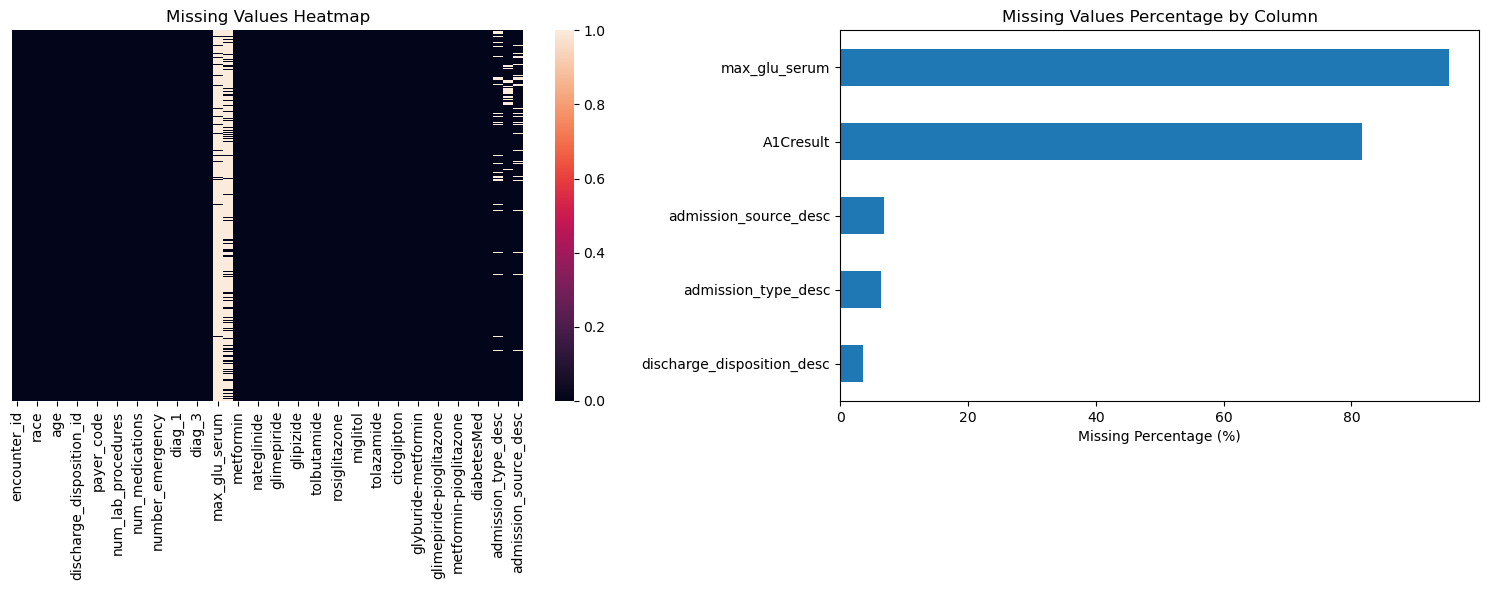

In [8]:
# 3.3 缺失值可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 缺失值热力图
missing_data = raw_data.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# 缺失值百分比条形图
missing_percentage_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=True)
missing_percentage_sorted.plot(kind='barh', ax=axes[1])
axes[1].set_title('Missing Values Percentage by Column')
axes[1].set_xlabel('Missing Percentage (%)')

plt.tight_layout()
plt.show()

In [9]:
# 3.4 缺失值处理决策（与Pipeline逻辑完全一致）
print("=== 缺失值处理决策（与Pipeline逻辑一致） ===")
print("基于data_preprocessor.py中的处理标准，我们生成以下决策表：")
print()

# --- 为了准确分析，先模拟pipeline的第一步：将'?'替换为NaN ---
analysis_df = raw_data.replace('?', np.nan)
missing_percentage = (analysis_df.isnull().sum() / len(analysis_df)) * 100

# --- 定义与pipeline完全一致的阈值和填充列 ---
drop_missing_threshold = 50.0
cols_to_fill_with_unknown = [
    'medical_specialty', 'payer_code', 'race',
    'diag_1', 'diag_2', 'diag_3',
    'admission_type_desc', 'discharge_disposition_desc', 'admission_source_desc'
]

# --- 生成与pipeline行为一致的决策表 ---
decision_data = []
all_missing_cols_df = missing_percentage[missing_percentage > 0]

for col, percentage in all_missing_cols_df.items():
    if percentage > drop_missing_threshold:
        action = "删除"
        reason = f"缺失率 ({percentage:.1f}%) > {drop_missing_threshold}%"
    elif col in cols_to_fill_with_unknown:
        action = "保留, 用'Unknown'填充"
        reason = f"预定义的填充列"
    else:
        action = "保留, 未指定处理"
        reason = "缺失率低但未在填充列表中"

    decision_data.append([col, f"{percentage:.1f}%", action, reason])

decision_df = pd.DataFrame(decision_data, columns=['列名', '缺失率', '处理方式', '原因'])
decision_df = decision_df.sort_values('缺失率', ascending=False)

print("📋 缺失值处理决策表 (与Pipeline同步):")
display(decision_df)

=== 缺失值处理决策（与Pipeline逻辑一致） ===
基于data_preprocessor.py中的处理标准，我们生成以下决策表：

📋 缺失值处理决策表 (与Pipeline同步):


,列名,缺失率,处理方式,原因
1,weight,96.0%,删除,缺失率 (96.0%) > 50.0%
7,max_glu_serum,95.2%,删除,缺失率 (95.2%) > 50.0%
8,A1Cresult,81.6%,删除,缺失率 (81.6%) > 50.0%
11,admission_source_desc,6.9%,"保留, 用'Unknown'填充",预定义的填充列
9,admission_type_desc,6.5%,"保留, 用'Unknown'填充",预定义的填充列
3,medical_specialty,48.1%,"保留, 用'Unknown'填充",预定义的填充列
2,payer_code,43.5%,"保留, 用'Unknown'填充",预定义的填充列
10,discharge_disposition_desc,3.5%,"保留, 用'Unknown'填充",预定义的填充列
0,race,2.7%,"保留, 用'Unknown'填充",预定义的填充列
6,diag_3,1.7%,"保留, 用'Unknown'填充",预定义的填充列


4. 数据集划分与编码

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(df)
X_train, X_val, X_test = preprocessor.encode_categorical_features(X_train, X_val, X_test)
X_train, X_val, X_test = preprocessor.scale_numerical_features(X_train, X_val, X_test)
X_train_balanced, y_train_balanced = preprocessor.apply_smote(X_train, y_train)
print(f'平衡后训练集样本数: {X_train_balanced.shape[0]}')

INFO:data_preprocessor:Splitting data into train/validation/test sets...
INFO:data_preprocessor:Dropping unused ID and target columns before splitting: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'readmitted']
INFO:data_preprocessor:Data split - Train: (44782, 52), Val: (11196, 52), Test: (13995, 52)
INFO:data_preprocessor:Encoding categorical features...
INFO:data_preprocessor:Scaling numerical features...
INFO:data_preprocessor:Applying SMOTE for class balancing...
INFO:data_preprocessor:Before SMOTE - Class distribution: {0: 40764, 1: 4018}
INFO:data_preprocessor:After SMOTE - Class distribution: {0: 40764, 1: 40764}


平衡后训练集样本数: 81528


5. 特征选择与可视化

In [11]:
# ===============================================================
#          多Top N值特征选择与结果展示
# ===============================================================

# 1. 设置您想要测试的top_n值列表
top_n_list = [5, 10, 15]  # 您可以随意修改这个列表
print(f"将要测试的Top N值: {top_n_list}")

# 2. 创建特征选择器
selector = FeatureSelector()

# 3. 运行多个top_n值的特征选择
print("\n🚀 开始运行多个Top N值的特征选择...")
multiple_results = selector.select_features_multiple_topn(
    X_train_balanced, 
    y_train_balanced, 
    top_n_list
)
print("✅ 特征选择完成！")


# 5. (可选) 选择一组特征进行后续步骤
#    您可以根据上面的表格结果，选择一组最满意的特征
#    例如，选择top_n=10时，L1方法选择的特征
# ---------------------------------------------------------------
# chosen_top_n = 10
# chosen_method = 'L1'
# X_selected = X_train_balanced[multiple_results[chosen_top_n][chosen_method]]
# print(f"\n proceeding with top_n={chosen_top_n} and method='{chosen_method}'")
# print(f"Selected {len(X_selected.columns)} features.")

INFO:feature_selector:Running feature selection with multiple top_n values: [5, 10, 15]
INFO:feature_selector:Processing top_n = 5
INFO:feature_selector:Running all feature selection methods with top_n=5...
INFO:feature_selector:Selecting top 5 features using L1 regularization...


将要测试的Top N值: [5, 10, 15]

🚀 开始运行多个Top N值的特征选择...


INFO:feature_selector:L1 feature selection completed. Selected features: ['age_midpoint', 'number_inpatient', 'payer_code', 'tolazamide', 'diabetesMed']
INFO:feature_selector:Selecting top 5 features using Mutual Information...
INFO:feature_selector:Mutual Information feature selection completed. Selected features: ['num_lab_procedures', 'num_medications', 'diag_2', 'diag_1', 'diag_3']
INFO:feature_selector:Selecting top 5 features using Tree-based importance...
INFO:feature_selector:Tree-based feature selection completed. Selected features: ['discharge_disposition_desc', 'age', 'age_midpoint', 'age_group', 'rolling_avg']
INFO:feature_selector:All feature selection methods completed
INFO:feature_selector:Processing top_n = 10
INFO:feature_selector:Running all feature selection methods with top_n=10...
INFO:feature_selector:Selecting top 10 features using L1 regularization...
INFO:feature_selector:L1 feature selection completed. Selected features: ['age_midpoint', 'number_inpatient', 'p

✅ 特征选择完成！



📊 多个Top N值特征选择详细结果:


,Top N,Method,Selected Features
0,5,L1,"[age_midpoint, number_inpatient, payer_code, tolazamide, diabetesMed]"
1,5,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3]"
2,5,TreeImportance,"[discharge_disposition_desc, age, age_midpoint, age_group, rolling_avg]"
3,10,L1,"[age_midpoint, number_inpatient, payer_code, tolazamide, diabetesMed, diag_1_category, num_proce..."
4,10,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3, rolling_avg, time_in_hospital, age..."
5,10,TreeImportance,"[discharge_disposition_desc, age, age_midpoint, age_group, rolling_avg, time_in_hospital, num_pr..."
6,15,L1,"[age_midpoint, number_inpatient, payer_code, tolazamide, diabetesMed, diag_1_category, num_proce..."
7,15,MutualInfo,"[num_lab_procedures, num_medications, diag_2, diag_1, diag_3, rolling_avg, time_in_hospital, age..."
8,15,TreeImportance,"[discharge_disposition_desc, age, age_midpoint, age_group, rolling_avg, time_in_hospital, num_pr..."


INFO:feature_selector:Found 1 features selected by at least 2 methods
INFO:feature_selector:Found 0 features selected by at least 3 methods
INFO:feature_selector:Found 8 features selected by at least 2 methods
INFO:feature_selector:Found 2 features selected by at least 3 methods
INFO:feature_selector:Found 14 features selected by at least 2 methods
INFO:feature_selector:Found 5 features selected by at least 3 methods



🔍 各Top N值下的共同特征总结:


,Top N,Common Features (>=2 methods),Common Features (all 3 methods)
0,5,[age_midpoint],[]
1,10,"[age_midpoint, num_procedures, admission_source_desc, time_in_hospital, diag_3, rolling_avg, age...","[age_midpoint, time_in_hospital]"
2,15,"[age_midpoint, diag_1_category, num_procedures, number_diagnoses, admission_source_desc, time_in...","[age_midpoint, diag_1_category, num_procedures, number_diagnoses, time_in_hospital]"



🎨 生成特征选择矩阵可视化图表:


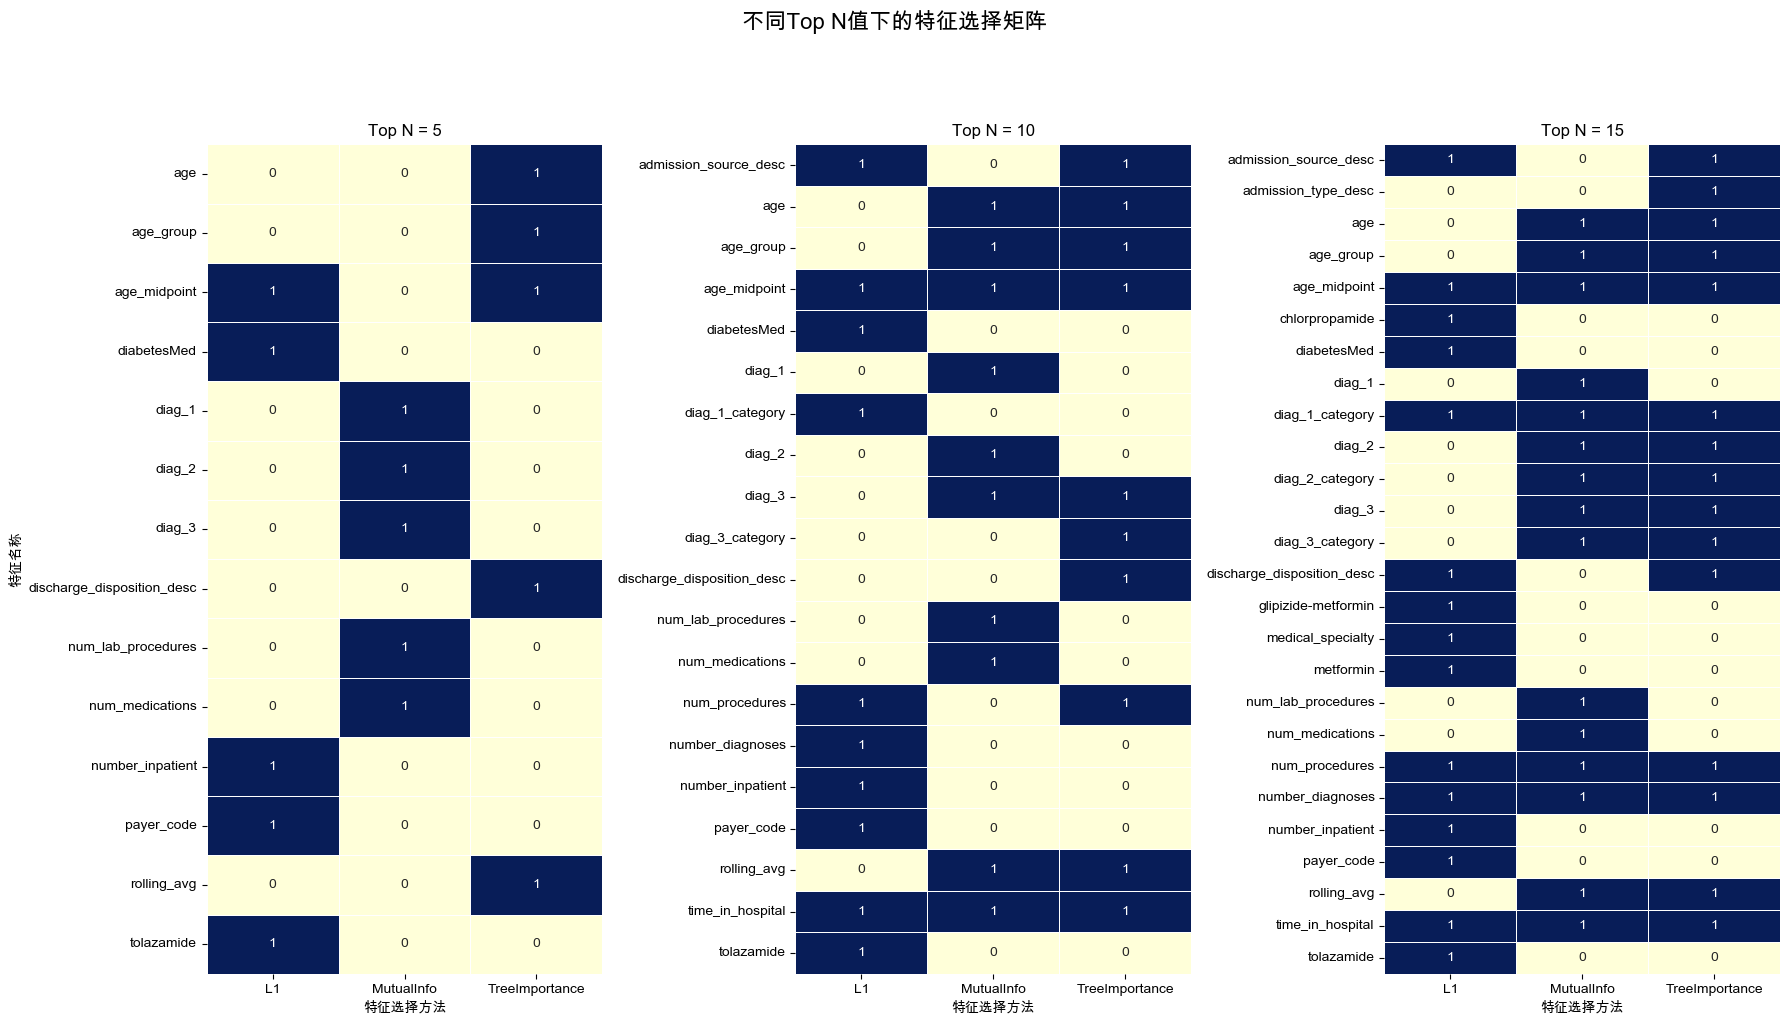

In [12]:

# 4. 以表格形式显示结果
selector.display_multiple_topn_results(multiple_results)

# 5. [新增] 可视化特征选择矩阵
selector.plot_feature_selection_matrix(multiple_results)

# ============

6. 模型训练与评估

In [13]:
# ====================================================================
#          多特征集模型训练与性能对比
# ====================================================================

# 1. 初始化模型训练器
model_trainer = ModelTrainer()

# 2. 传入之前选择的多个特征集(multiple_results)，进行模型训练
print("\n🚀 开始为所有特征集训练模型...")
training_results_df = model_trainer.train_models_for_feature_sets(
    multiple_results,   # 这是上一步特征选择得到的结果
    X_train_balanced,
    y_train_balanced
)
print("✅ 所有模型训练完成!")

# 3. 以表格和透视表展示详细的训练结果
#    您可以选择不同的指标来查看，例如 'cv_auc' 或 'cv_f1'
model_trainer.display_training_results(training_results_df, metric='cv_f1')

INFO:model_trainer:Starting model training for multiple feature sets...
INFO:model_trainer:--- Training for: top_n=5, method=L1 ---
INFO:model_trainer:Training all models...
INFO:model_trainer:Training LogisticRegression...



🚀 开始为所有特征集训练模型...


INFO:model_trainer:LogisticRegression training completed - CV AUC: 0.591, CV F1: 0.572
INFO:model_trainer:Training RandomForest...


In [ ]:
# ===============================================================
#          [新增] 特征分类分析与可视化
# ===============================================================
from result_analyzer import ResultAnalyzer

# 1. 初始化分析器
analyzer = ResultAnalyzer()

# 2. 传入特征选择的结果，进行深入的分类分析
#    这个函数会自动打印表格和绘制图表
analyzer.analyze_feature_categories(multiple_results)

7. 总结与输出

In [15]:
# ====================================================================
#          寻找并总结最佳模型配置
# ====================================================================

# 1. 确定我们用来决策的核心指标
#    对于不平衡数据集，'cv_f1' 通常是比 'cv_auc' 更好的选择
decision_metric = 'cv_f1'
print(f"🚀 开始寻找基于 '{decision_metric}' 指标的最佳模型配置...")

# 2. 在所有训练结果中，找到表现最好的那一行
best_config_row = training_results_df.loc[training_results_df[decision_metric].idxmax()]

# 3. 从这“最佳的一行”中，提取出所有的关键信息
best_top_n = int(best_config_row['top_n'])
best_feature_method = best_config_row['feature_method']
best_model_name = best_config_row['model_name']
best_performance = best_config_row[decision_metric]

# 4. 清晰地打印出最佳配置的总结
print("\\n" + "="*50)
print("          🏆 最佳模型配置总结 🏆")
print("="*50)
print(f"评估指标:     {decision_metric}")
print(f"最佳性能得分: {best_performance:.4f}")
print("-" * 50)
print(f"特征数量 (top_n): {best_top_n}")
print(f"特征选择方法:   {best_feature_method}")
print(f"机器学习模型:   {best_model_name}")
print("="*50)

# 提醒：最终在测试集上的评估，应该使用这个最佳配置重新训练模型来完成。
print("\\n下一步建议: 使用上面找到的最佳配置, 在完整的训练集上重新训练模型,")
print("然后用独立的测试集(test set)进行最终的、公正的性能评估。")

NameError: name 'trainer' is not defined

In [ ]:
# ====================================================================
#          [新增] 1. 绘制性能随特征数量变化的曲线
# ====================================================================
# 这个图表能帮我们直观地看到特征数量的“临界点”
model_trainer.plot_performance_vs_top_n(training_results_df)


# ====================================================================
#          [新增] 2. 对最终的冠军模型进行全面的健壮性评估
# ====================================================================
print("\\n" + "#"*70)
print("###      进行最终、独立的测试集评估      ###")
print("#"*70)

# 1. 我们需要从之前的分析中，拿出“最佳配置”
#    这里的'best_config_row'来自于您上一段代码的输出
best_config_dict = {
    'top_n': int(best_config_row['top_n']),
    'feature_method': best_config_row['feature_method'],
    'model_name': best_config_row['model_name'],
    # 还需要当时选出的那一组特征
    'features': multiple_results[int(best_config_row['top_n'])][best_config_row['feature_method']]
}

print("\\n🏆 使用以下冠军配置进行最终评估:")
for key, value in best_config_dict.items():
    if key != 'features':
        print(f"  - {key}: {value}")

# 2. 从完整的训练集和测试集中，只选取我们需要的最佳特征
X_train_final = X_train_balanced[best_config_dict['features']]
X_test_final = X_test[best_config_dict['features']]

# 3. 调用我们全新的评估函数，它会自动完成所有工作
model_trainer.evaluate_final_model(
    best_config=best_config_dict,
    X_train=X_train_final,
    y_train=y_train_balanced,
    X_test=X_test_final,
    y_test=y_test
)